In [1]:
from isrobust.nbutils import pick_gpu_lowest_memory, setup_one_gpu

print(pick_gpu_lowest_memory())
setup_one_gpu()

0
Picking GPU 0


In [2]:
# %%
# https://www.sc-best-practices.org/conditions/gsea_pathway.html#id380
# Kang HM, Subramaniam M, Targ S, et al. Multiplexed droplet single-cell RNA-sequencing using natural genetic variation
#   Nat Biotechnol. 2020 Nov;38(11):1356]. Nat Biotechnol. 2018;36(1):89-94. doi:10.1038/nbt.4042

# %%


from pathlib import Path

import dotenv
import numpy as np
import pandas as pd
import scanpy as sc

# from pathlib import Path
# import dotenv
# import numpy as np
# import pandas as pd
# import scanpy as sc
# from ivae_scorer.bio import (
#     build_hipathia_renamers,
#     get_adj_matrices,
#     get_reactome_adj,
#     sync_gexp_adj,
# )
# from ivae_scorer.datasets import load_kang
# from ivae_scorer.utils import set_all_seeds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from tensorflow.keras import callbacks

from isrobust.bio import (
    build_hipathia_renamers,
    get_adj_matrices,
    get_reactome_adj,
    sync_gexp_adj,
)
from isrobust.datasets import load_kang
from isrobust.models import build_kegg_vae
from isrobust.utils import set_all_seeds

model_kind = "binn-reactome"
debug = 1
seed = 42
model_kind = str(model_kind)
debug = bool(int(debug))
seed = int(seed)


project_path = Path(dotenv.find_dotenv()).parent
results_path = project_path.joinpath("results")
results_path.mkdir(exist_ok=True, parents=True)
data_path = project_path.joinpath("data")
data_path.mkdir(exist_ok=True, parents=True)
mygene_path = data_path.joinpath("mygene")
mygene_path.mkdir(exist_ok=True, parents=True)
figs_path = results_path.joinpath("figs")
figs_path.mkdir(exist_ok=True, parents=True)
tables_path = results_path.joinpath("tables")
tables_path.mkdir(exist_ok=True, parents=True)

set_all_seeds(seed=seed)

sc.set_figure_params(dpi=300, color_map="inferno")
sc.settings.verbosity = 1
sc.logging.print_header()

print(f"{debug=} {model_kind=}")

2024-09-20 07:24:26.050551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cloucera/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.24.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.1 statsmodels==0.14.0 igraph==0.10.3 pynndescent==0.5.13
debug=True model_kind='binn-reactome'


In [3]:
atlas = sc.read(
    data_path.joinpath("theis", "pbmc_vars_sb.h5ad"),
    cache=False,
)

atlas = atlas[atlas.obs["study"] != "Villani"].copy()
atlas.X = atlas.layers["counts"].copy()
sc.pp.normalize_total(atlas)
sc.pp.log1p(atlas)

/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [4]:
atlas.obs

batch chemistry data_type  \
index                                                                   
AAACCTGCAGCGAACA-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
AAACCTGCATGTCCTC-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
AAACCTGGTCGACTGC-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
AAACCTGGTCGCTTCT-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
AAACCTGTCCCGACTT-1-Oetjen_A              Oetjen_A    v2_10X       UMI   
...                                           ...       ...       ...   
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   
TTTGTCATCATCATTC-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   
TTTGTCATCTCGCTTG-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   
TTTGTCATCTGTCTCG-1-Sun_sample4_TC  Sun_sample4_TC       10X       UMI   

                                   dpt_pseudotime final_annotation   mt_frac  \
index                                                                          
AAACCTGCAGCGAACA-1-Oetjen_A                   NaN  CD16+ Monocytes  0.047970   
AAACCTGCATGTCCTC-1-Oetjen_A                   NaN     CD4+ T cells  0.024928   
AAACCTGGTCGACTGC-1-Oetjen_A                   NaN  CD14+ Monocytes  0.051907   
AAACCTGGTCGCTTCT-1-Oetjen_A                   NaN  CD14+ Monocytes  0.041716   
AAACCTGTCCCGACTT-1-Oetjen_A                   NaN        NKT cells  0.043522   
...                                           ...              ...       ...   
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC             NaN  CD14+ Monocytes  0.059215   
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC             NaN  CD14+ Monocytes  0.051119   
TTTGTCATCATCATTC-1-Sun_sample4_TC             NaN         NK cells  0.038078   
TTTGTCATCTCGCTTG-1-Sun_sample4_TC             NaN         NK cells  0.052873   
TTTGTCATCTGTCTCG-1-Sun_sample4_TC             NaN     CD4+ T cells  0.019406   

                                   n_counts  n_genes sample_ID  size_factors  \
index                                                                          
AAACCTGCAGCGAACA-1-Oetjen_A          6379.0   1862.0         0      0.957719   
AAACCTGCATGTCCTC-1-Oetjen_A          4172.0   1082.0         0      0.425532   
AAACCTGGTCGACTGC-1-Oetjen_A          6608.0   1618.0         0      0.773111   
AAACCTGGTCGCTTCT-1-Oetjen_A          5034.0   1413.0         0      0.641188   
AAACCTGTCCCGACTT-1-Oetjen_A          3998.0   1127.0         0      0.452426   
...                                     ...      ...       ...           ...   
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    3006.0   1111.0         3      0.825529   
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    5810.0   1723.0         3      1.584353   
TTTGTCATCATCATTC-1-Sun_sample4_TC    2705.0   1209.0         3      0.978014   
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    2837.0   1045.0         3      0.793495   
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    3504.0    915.0         3      0.677142   

                                  species   study       tissue  
index                                                           
AAACCTGCAGCGAACA-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
AAACCTGCATGTCCTC-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
AAACCTGGTCGACTGC-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
AAACCTGGTCGCTTCT-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
AAACCTGTCCCGACTT-1-Oetjen_A         Human  Oetjen  Bone_Marrow  
...                                   ...     ...          ...  
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC   Human     Sun        PBMCs  
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC   Human     Sun        PBMCs  
TTTGTCATCATCATTC-1-Sun_sample4_TC   Human     Sun        PBMCs  
TTTGTCATCTCGCTTG-1-Sun_sample4_TC   Human     Sun        PBMCs  
TTTGTCATCTGTCTCG-1-Sun_sample4_TC   Human     Sun        PBMCs  

[32484 rows x 13 columns]

In [5]:
# %%
adata = load_kang(data_folder=data_path, normalize=True, n_genes=4000)

# %%
x_trans = adata.to_df()

obs = adata.obs

/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [6]:
adata

View of AnnData object with n_obs × n_vars = 24673 × 4000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [7]:
x_trans.shape

(24673, 4000)

In [8]:
obs

nCount_RNA  nFeature_RNA      tsne1      tsne2   condition  \
index                                                                          
AAACATACATTTCC-1      3017.0           877 -27.640373  14.966629     control   
AAACATACCAGAAA-1      2481.0           713 -27.493646  28.924885     control   
AAACATACCATGCA-1       703.0           337 -10.468194  -5.984389     control   
AAACATACCTCGCT-1      3420.0           850 -24.367997  20.429285     control   
AAACATACCTGGTA-1      3158.0          1111  27.952170  24.159738     control   
...                      ...           ...        ...        ...         ...   
TTTGCATGCCTGAA-2      1033.0           468  18.268321   1.058202  stimulated   
TTTGCATGCCTGTC-2      2116.0           819 -11.563067   2.574095  stimulated   
TTTGCATGCTAAGC-2      1522.0           523  25.142392   6.603815  stimulated   
TTTGCATGGGACGA-2      1143.0           503  14.359657  10.965601  stimulated   
TTTGCATGTCTTAC-2      1031.0           421  14.572118  -4.713942  stimulated   

                  cluster        cell_type     replicate  nCount_SCT  \
index                                                                  
AAACATACATTTCC-1        9  CD14+ Monocytes  patient_1016      1704.0   
AAACATACCAGAAA-1        9  CD14+ Monocytes  patient_1256      1614.0   
AAACATACCATGCA-1        3      CD4 T cells  patient_1488       908.0   
AAACATACCTCGCT-1        9  CD14+ Monocytes  patient_1256      1738.0   
AAACATACCTGGTA-1        4  Dendritic cells  patient_1039      1857.0   
...                   ...              ...           ...         ...   
TTTGCATGCCTGAA-2        6      CD4 T cells  patient_1244      1128.0   
TTTGCATGCCTGTC-2        4          B cells  patient_1256      1669.0   
TTTGCATGCTAAGC-2        6      CD4 T cells   patient_107      1422.0   
TTTGCATGGGACGA-2        6      CD4 T cells  patient_1488      1185.0   
TTTGCATGTCTTAC-2        5      CD4 T cells  patient_1016      1144.0   

                  nFeature_SCT integrated_snn_res.0.4 seurat_clusters  
index                                                                  
AAACATACATTTCC-1           711                      1               1  
AAACATACCAGAAA-1           662                      1               1  
AAACATACCATGCA-1           337                      6               6  
AAACATACCTCGCT-1           653                      1               1  
AAACATACCTGGTA-1           928                     12              12  
...                        ...                    ...             ...  
TTTGCATGCCTGAA-2           468                      2               2  
TTTGCATGCCTGTC-2           799                      3               3  
TTTGCATGCTAAGC-2           523                      0               0  
TTTGCATGGGACGA-2           503                      0               0  
TTTGCATGTCTTAC-2           419                      2               2  

[24673 rows x 12 columns]

In [9]:
atlas_x = atlas.to_df()
atlas_obs = atlas.obs.copy()

In [10]:
obs.cell_type.unique().tolist()

['CD14+ Monocytes',
 'CD4 T cells',
 'Dendritic cells',
 'NK cells',
 'CD8 T cells',
 'B cells',
 'FCGR3A+ Monocytes',
 'Megakaryocytes']

In [11]:
atlas_obs.final_annotation.unique().tolist()

['CD16+ Monocytes',
 'CD4+ T cells',
 'CD14+ Monocytes',
 'NKT cells',
 'HSPCs',
 'CD8+ T cells',
 'Erythrocytes',
 'CD10+ B cells',
 'Plasmacytoid dendritic cells',
 'Monocyte progenitors',
 'CD20+ B cells',
 'Monocyte-derived dendritic cells',
 'Plasma cells',
 'Erythroid progenitors',
 'Megakaryocyte progenitors',
 'NK cells']

In [12]:
genes = atlas_x.columns.intersection(x_trans.columns)
x_trans = x_trans[genes]
atlas_x = atlas_x[genes]

In [13]:
# %%
circuit_adj, circuit_to_pathway_adj = get_adj_matrices(
    gene_list=x_trans.columns.to_list()
)

circuit_renamer, pathway_renamer, circuit_to_effector = build_hipathia_renamers()

kegg_circuit_names = circuit_adj.rename(columns=circuit_renamer).columns

kegg_pathway_names = circuit_to_pathway_adj.rename(columns=pathway_renamer).columns

circuit_adj.head()

# %%
reactome = get_reactome_adj()
reactome_pathway_names = reactome.columns

x_trans, circuit_adj = sync_gexp_adj(gexp=x_trans, adj=circuit_adj)
atlas_x = atlas_x[x_trans.columns]

In [14]:
# %%
def train_val_test_split(features, val_size, test_size, stratify, seed):
    train_size = 1 - (val_size + test_size)

    x_train, x_test, y_train, y_test = train_test_split(
        features,
        stratify,
        train_size=train_size,
        stratify=stratify,
        random_state=seed,
    )

    x_val, x_test, y_val, y_test = train_test_split(
        x_test,
        y_test,
        test_size=test_size / (test_size + val_size),
        stratify=y_test,
        random_state=seed,
    )

    x_train = x_train.astype("float32")
    x_val = x_val.astype("float32")
    x_test = x_test.astype("float32")

    return x_train, x_val, x_test, y_train, y_val, y_test


def get_importances(data, abs=False):
    if abs:
        return np.abs(data).mean(axis=0)
    else:
        return data.mean(axis=0)


def get_actiations(act_model, layer_id, data):
    data_encoded = act_model.predict(data)[layer_id]
    return data_encoded

In [15]:
from sklearn.preprocessing import OneHotEncoder

x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
    x_trans.apply(minmax_scale),
    val_size=0.20,
    test_size=0.20,
    stratify=obs["cell_type"].astype(str) + obs["condition"].astype(str),
    seed=42,
)

y_train = obs["cell_type"][y_train.index]
y_val = obs["cell_type"][y_val.index]
y_test = obs["cell_type"][y_test.index]

label_encoder = OneHotEncoder(sparse_output=False).fit(y_train.to_frame())
y_train_encoded = label_encoder.transform(y_train.to_frame())
y_val_encoded = label_encoder.transform(y_val.to_frame())
y_test_encoded = label_encoder.transform(y_test.to_frame())

In [16]:
batch_size = 32

callback = callbacks.EarlyStopping(
    monitor="val_loss",  # Stop training when `val_loss` is no longer improving
    min_delta=1e-1,  # "no longer improving" being defined as "no better than 1e-5 less"
    patience=500,  # "no longer improving" being further defined as "for at least 3 epochs"
    verbose=0,
)

vae, encoder, decoder = build_kegg_vae(
    circuits=circuit_adj, pathways=circuit_to_pathway_adj, seed=seed
)

history = vae.fit(
    x_train.values,
    shuffle=True,
    verbose=0,
    epochs=1000,
    batch_size=batch_size,
    callbacks=[callback],
    validation_data=(x_val.values, None),
)

2024-09-20 07:24:55.566399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 07:24:55.939131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79009 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-09-20 07:24:57.958650: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


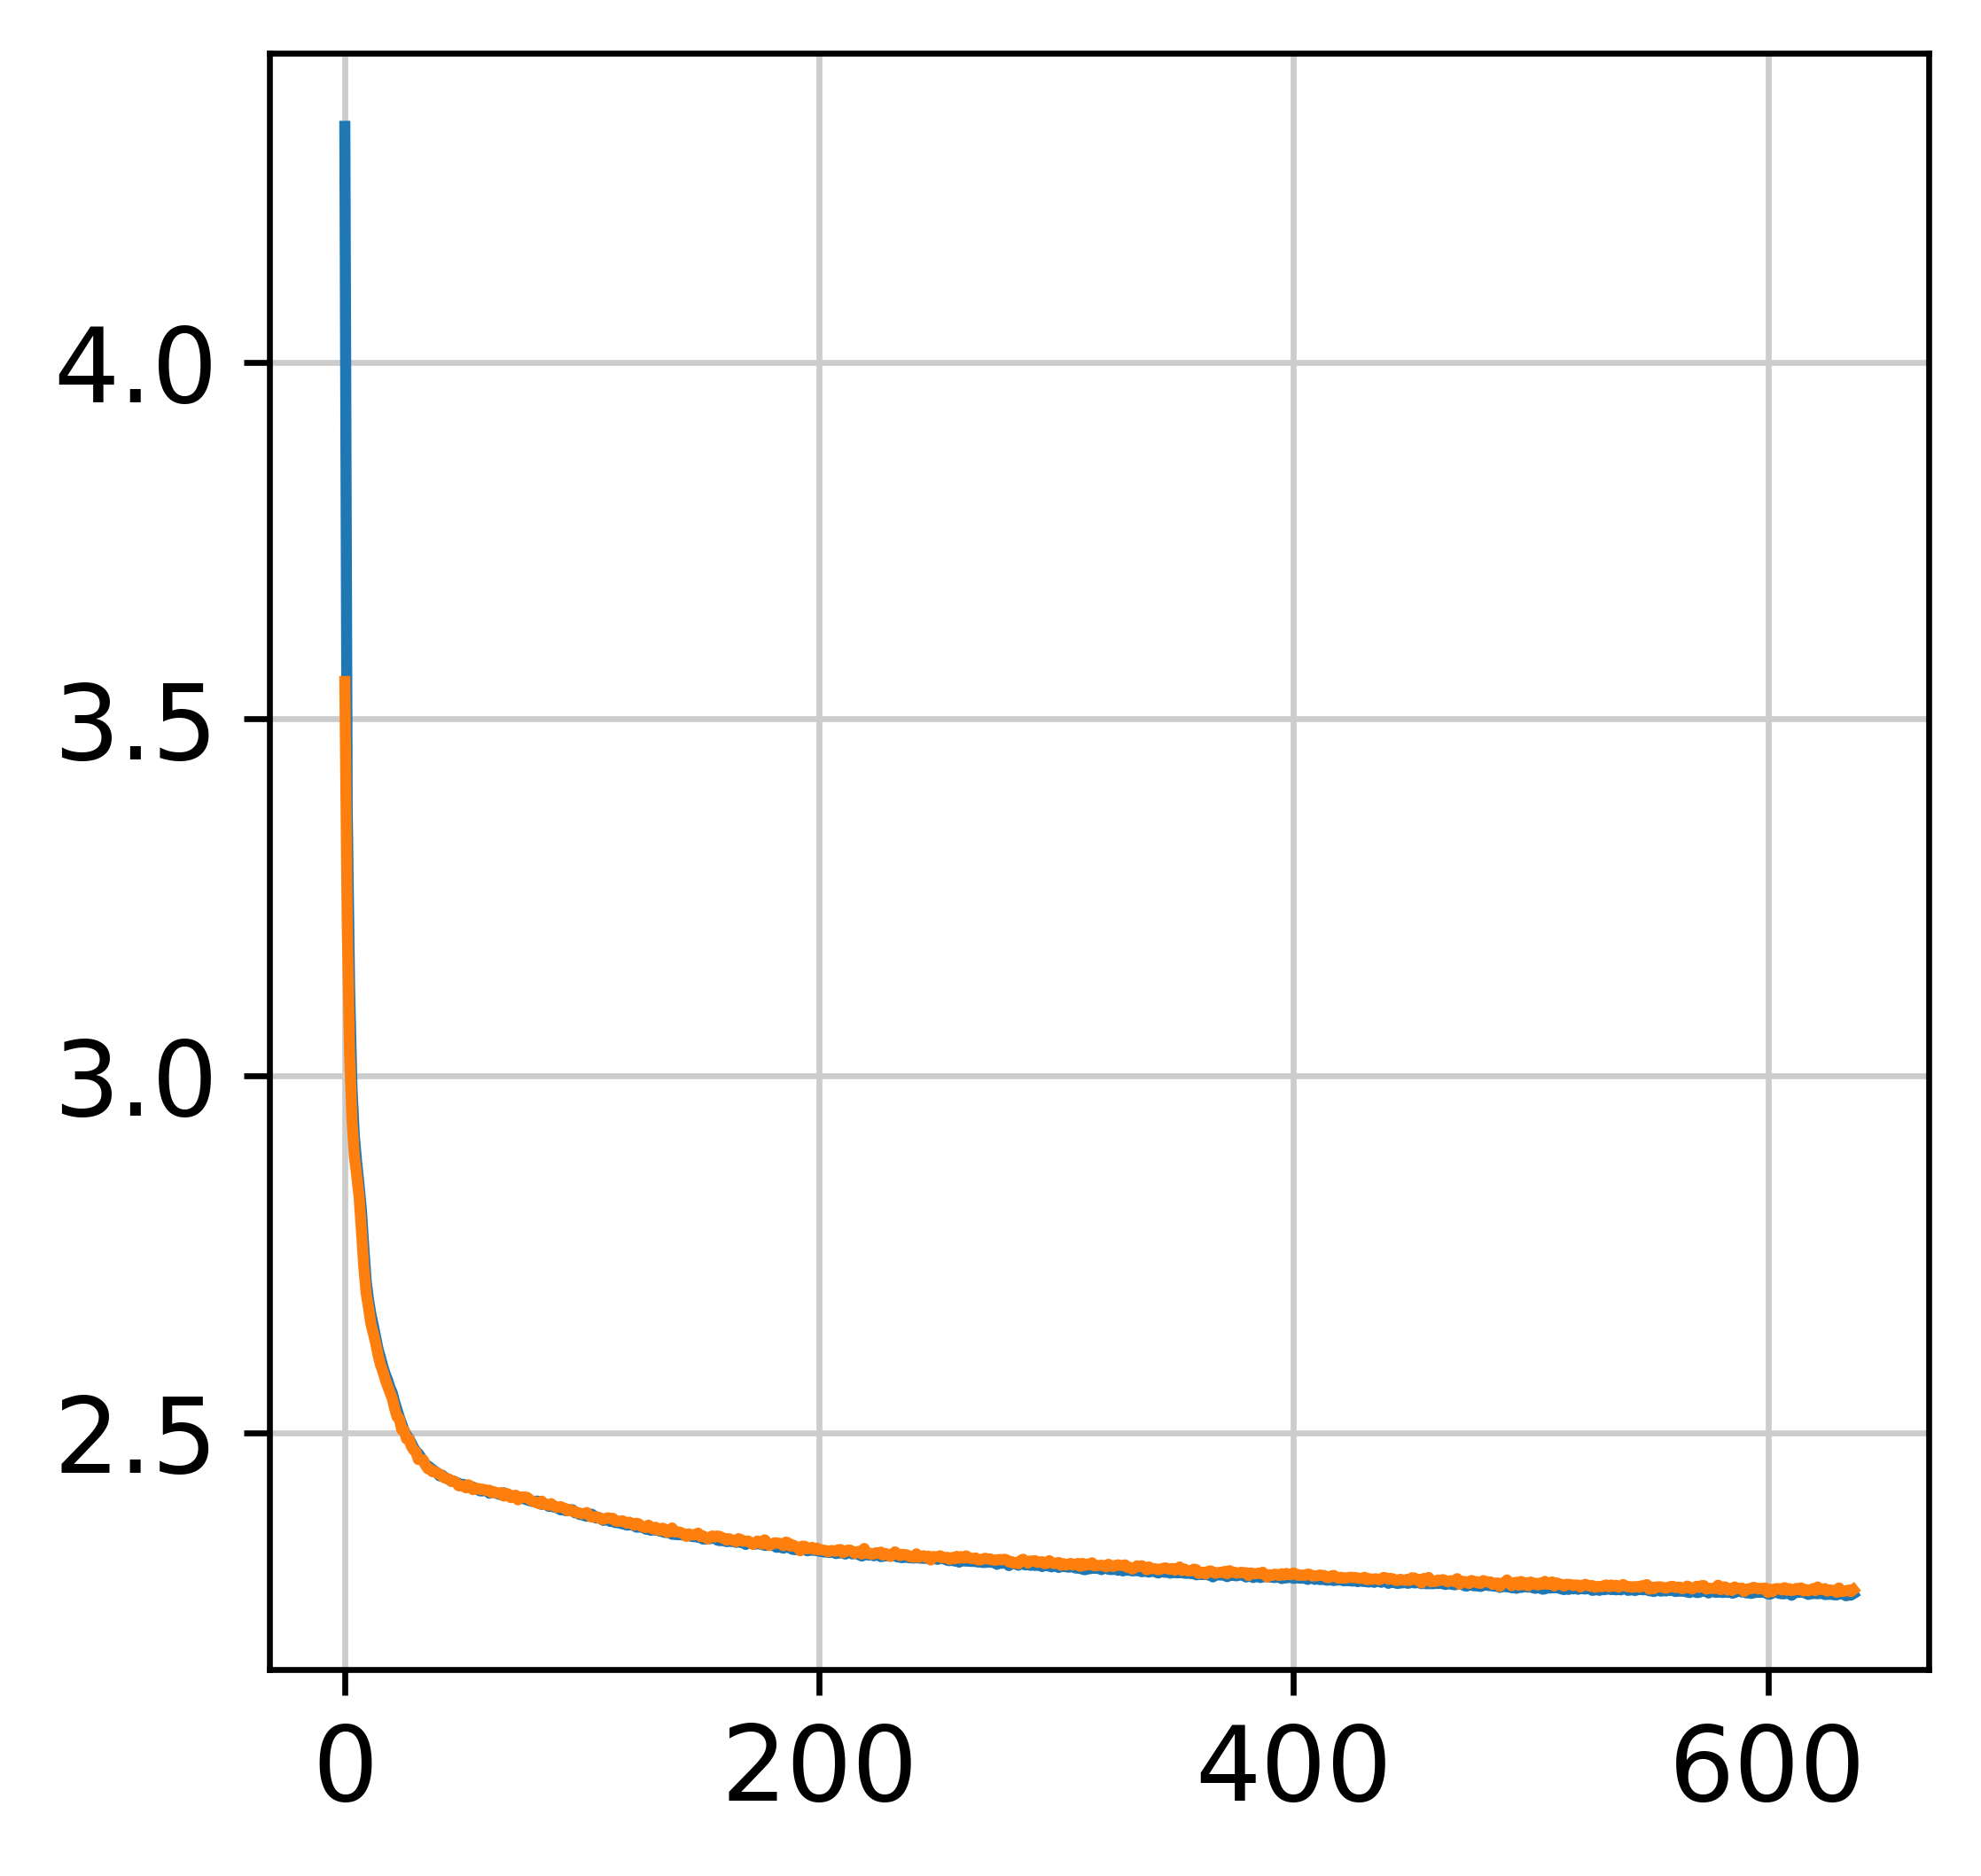

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [18]:
x_new = pd.concat((x_test, atlas_x.apply(minmax_scale)), axis=0)
kang_obs = (
    obs.loc[x_test.index, ["cell_type", "condition"]]
    .copy()
    .rename(columns={"cell_type": "final_annotation"})
)
kang_obs["study"] = "Kang"
y_new = pd.concat(
    (kang_obs, atlas_obs[["study", "final_annotation"]].assign(condition="atlas")),
    axis=0,
)

celltypes_replace = {}
celltypes_replace["CD20+ B cells"] = "B"
celltypes_replace["B cells"] = "B"
celltypes_replace["CD4 T cells"] = "CD4+ T cells"
celltypes_replace["CD8 T cells"] = "CD8+ T cells"
celltypes_replace["CD14 Mono"] = "CD14+ Monocytes"
celltypes_replace["CD16 Mono"] = "CD16+ Monocytes"
celltypes_replace["CD16 Mono"] = "CD16+ Monocytes"
celltypes_replace["NK"] = "NK cells"
y_new = y_new.replace({"final_annotation": celltypes_replace})

1170/1170 [==============================] - 1s 836us/step


/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-

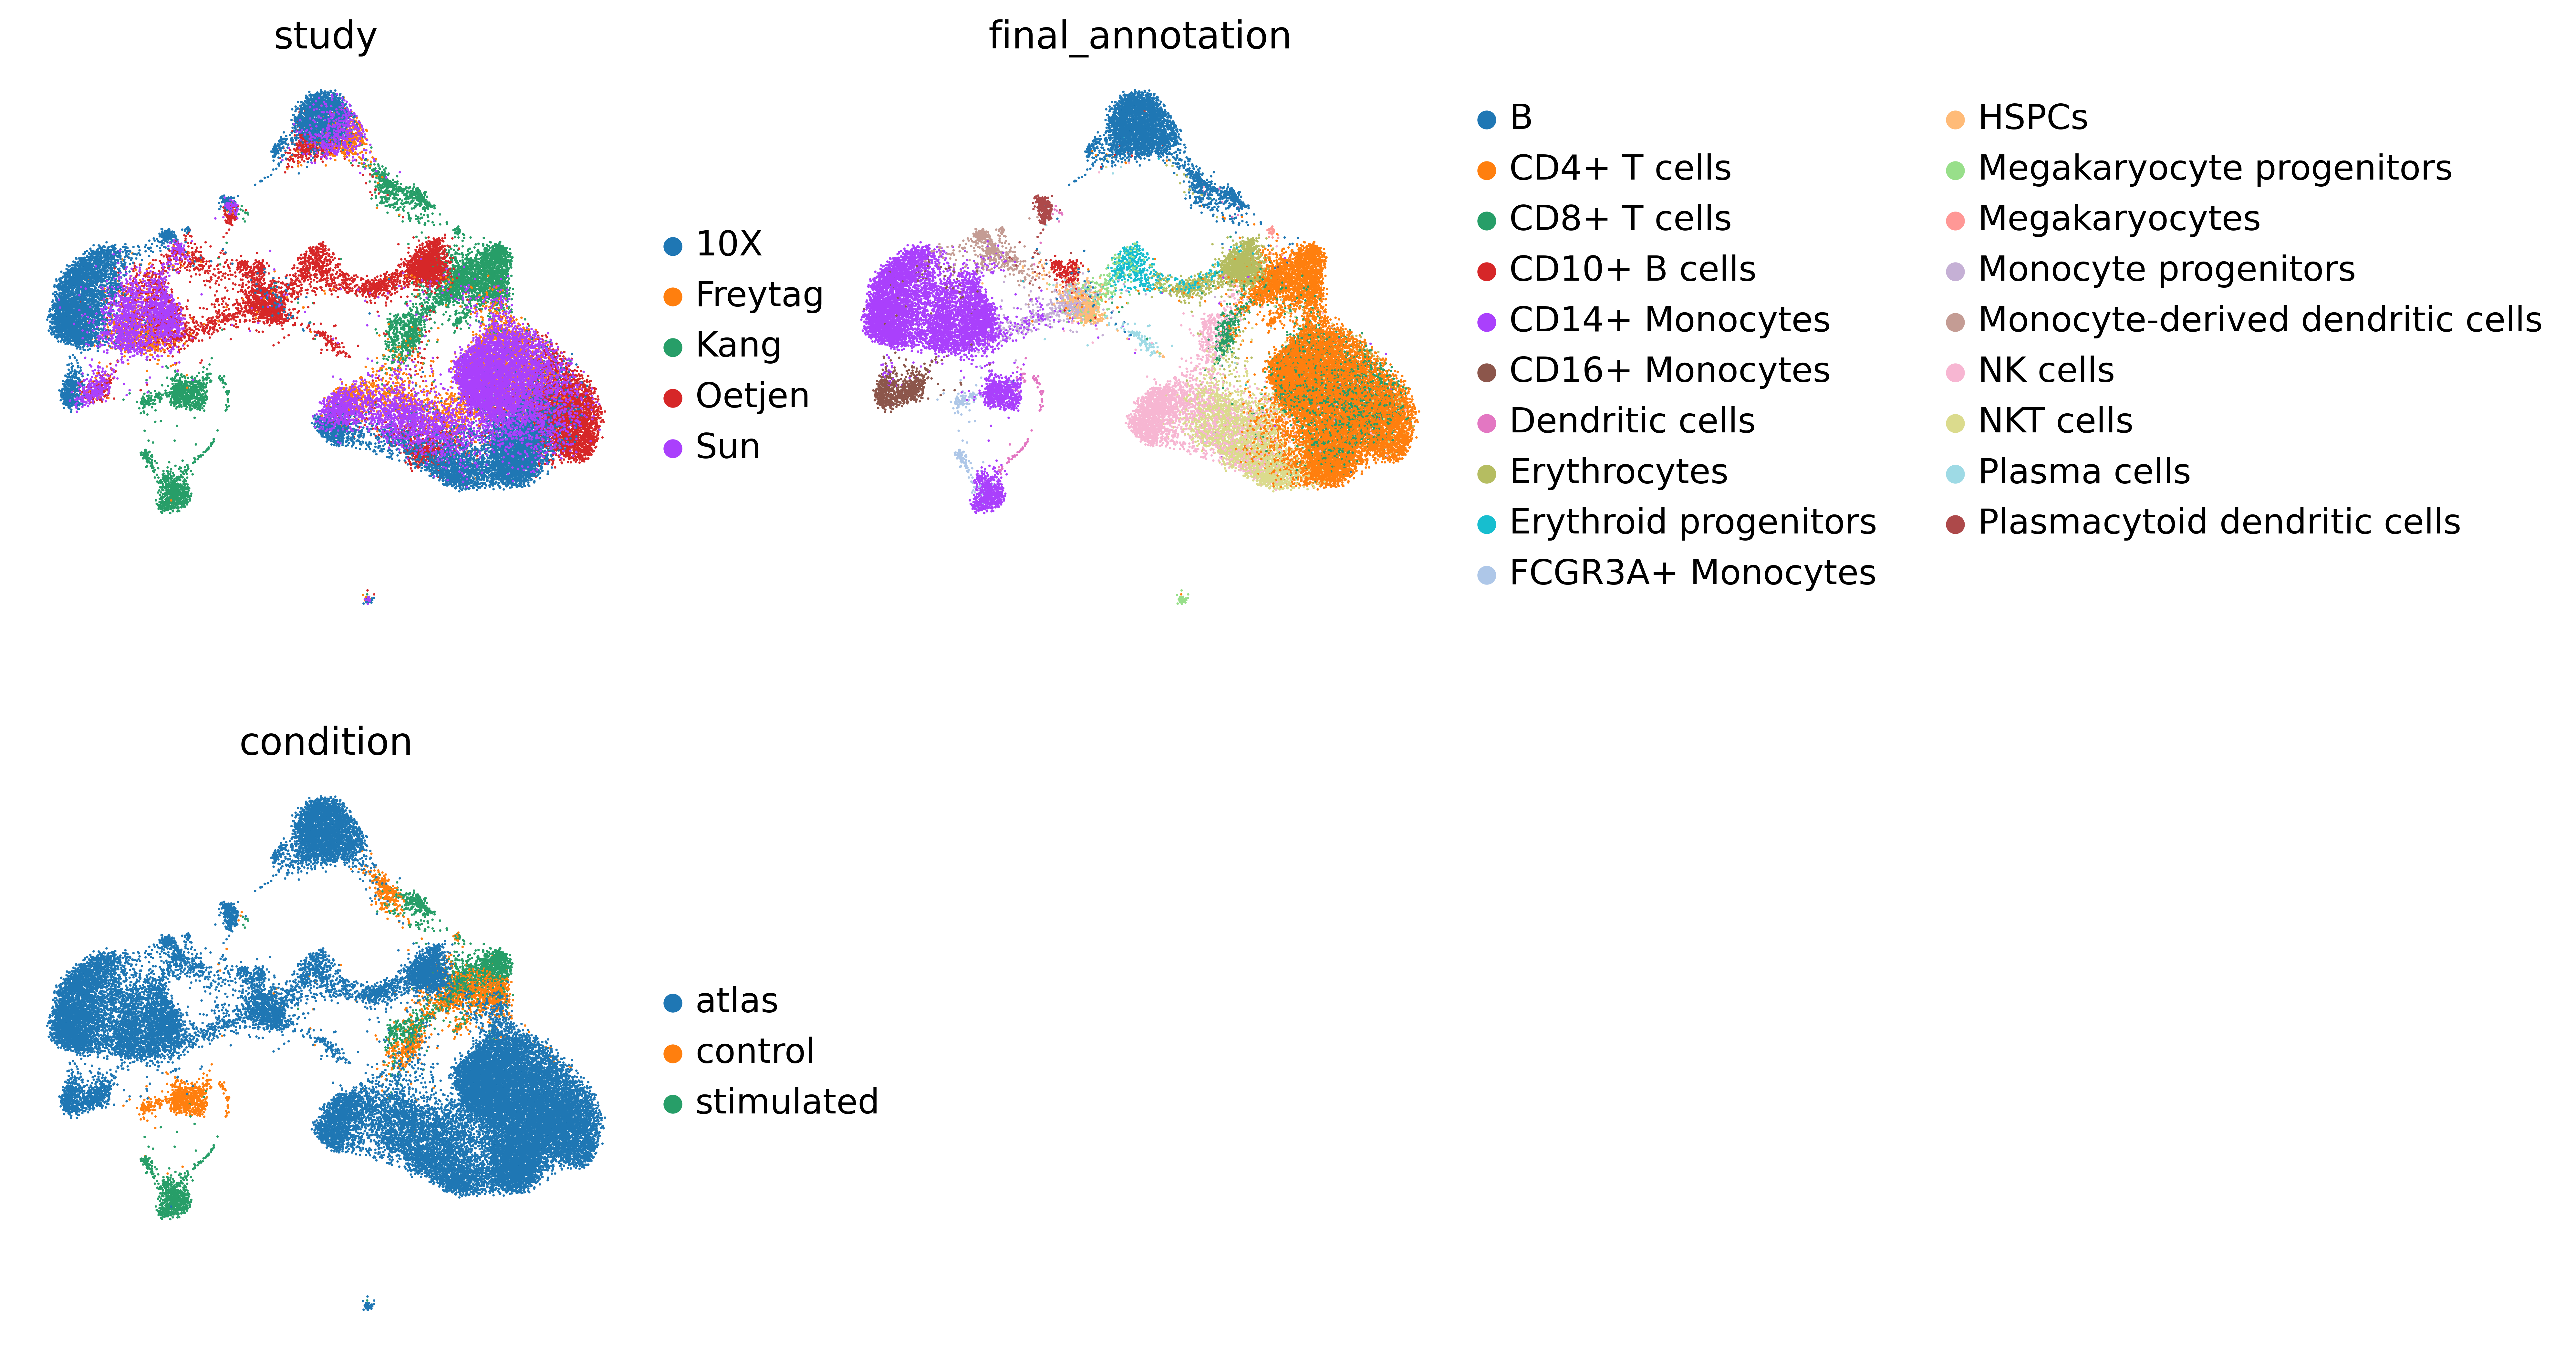

In [27]:
atlas_encoded = encoder.predict(x_new, batch_size=batch_size)[0]
atlas_encoded = pd.DataFrame(atlas_encoded, index=x_new.index)

adata = sc.AnnData(X=atlas_encoded)
adata.obs = y_new.loc[x_new.index]

# sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep="X", random_state=42)
# sc.tl.leiden(adata, random_state=42)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(
    adata, color=["study", "final_annotation", "condition"], frameon=False, ncols=2
)

/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cloucera/github/robustness_informed/.pixi/envs/default/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the des

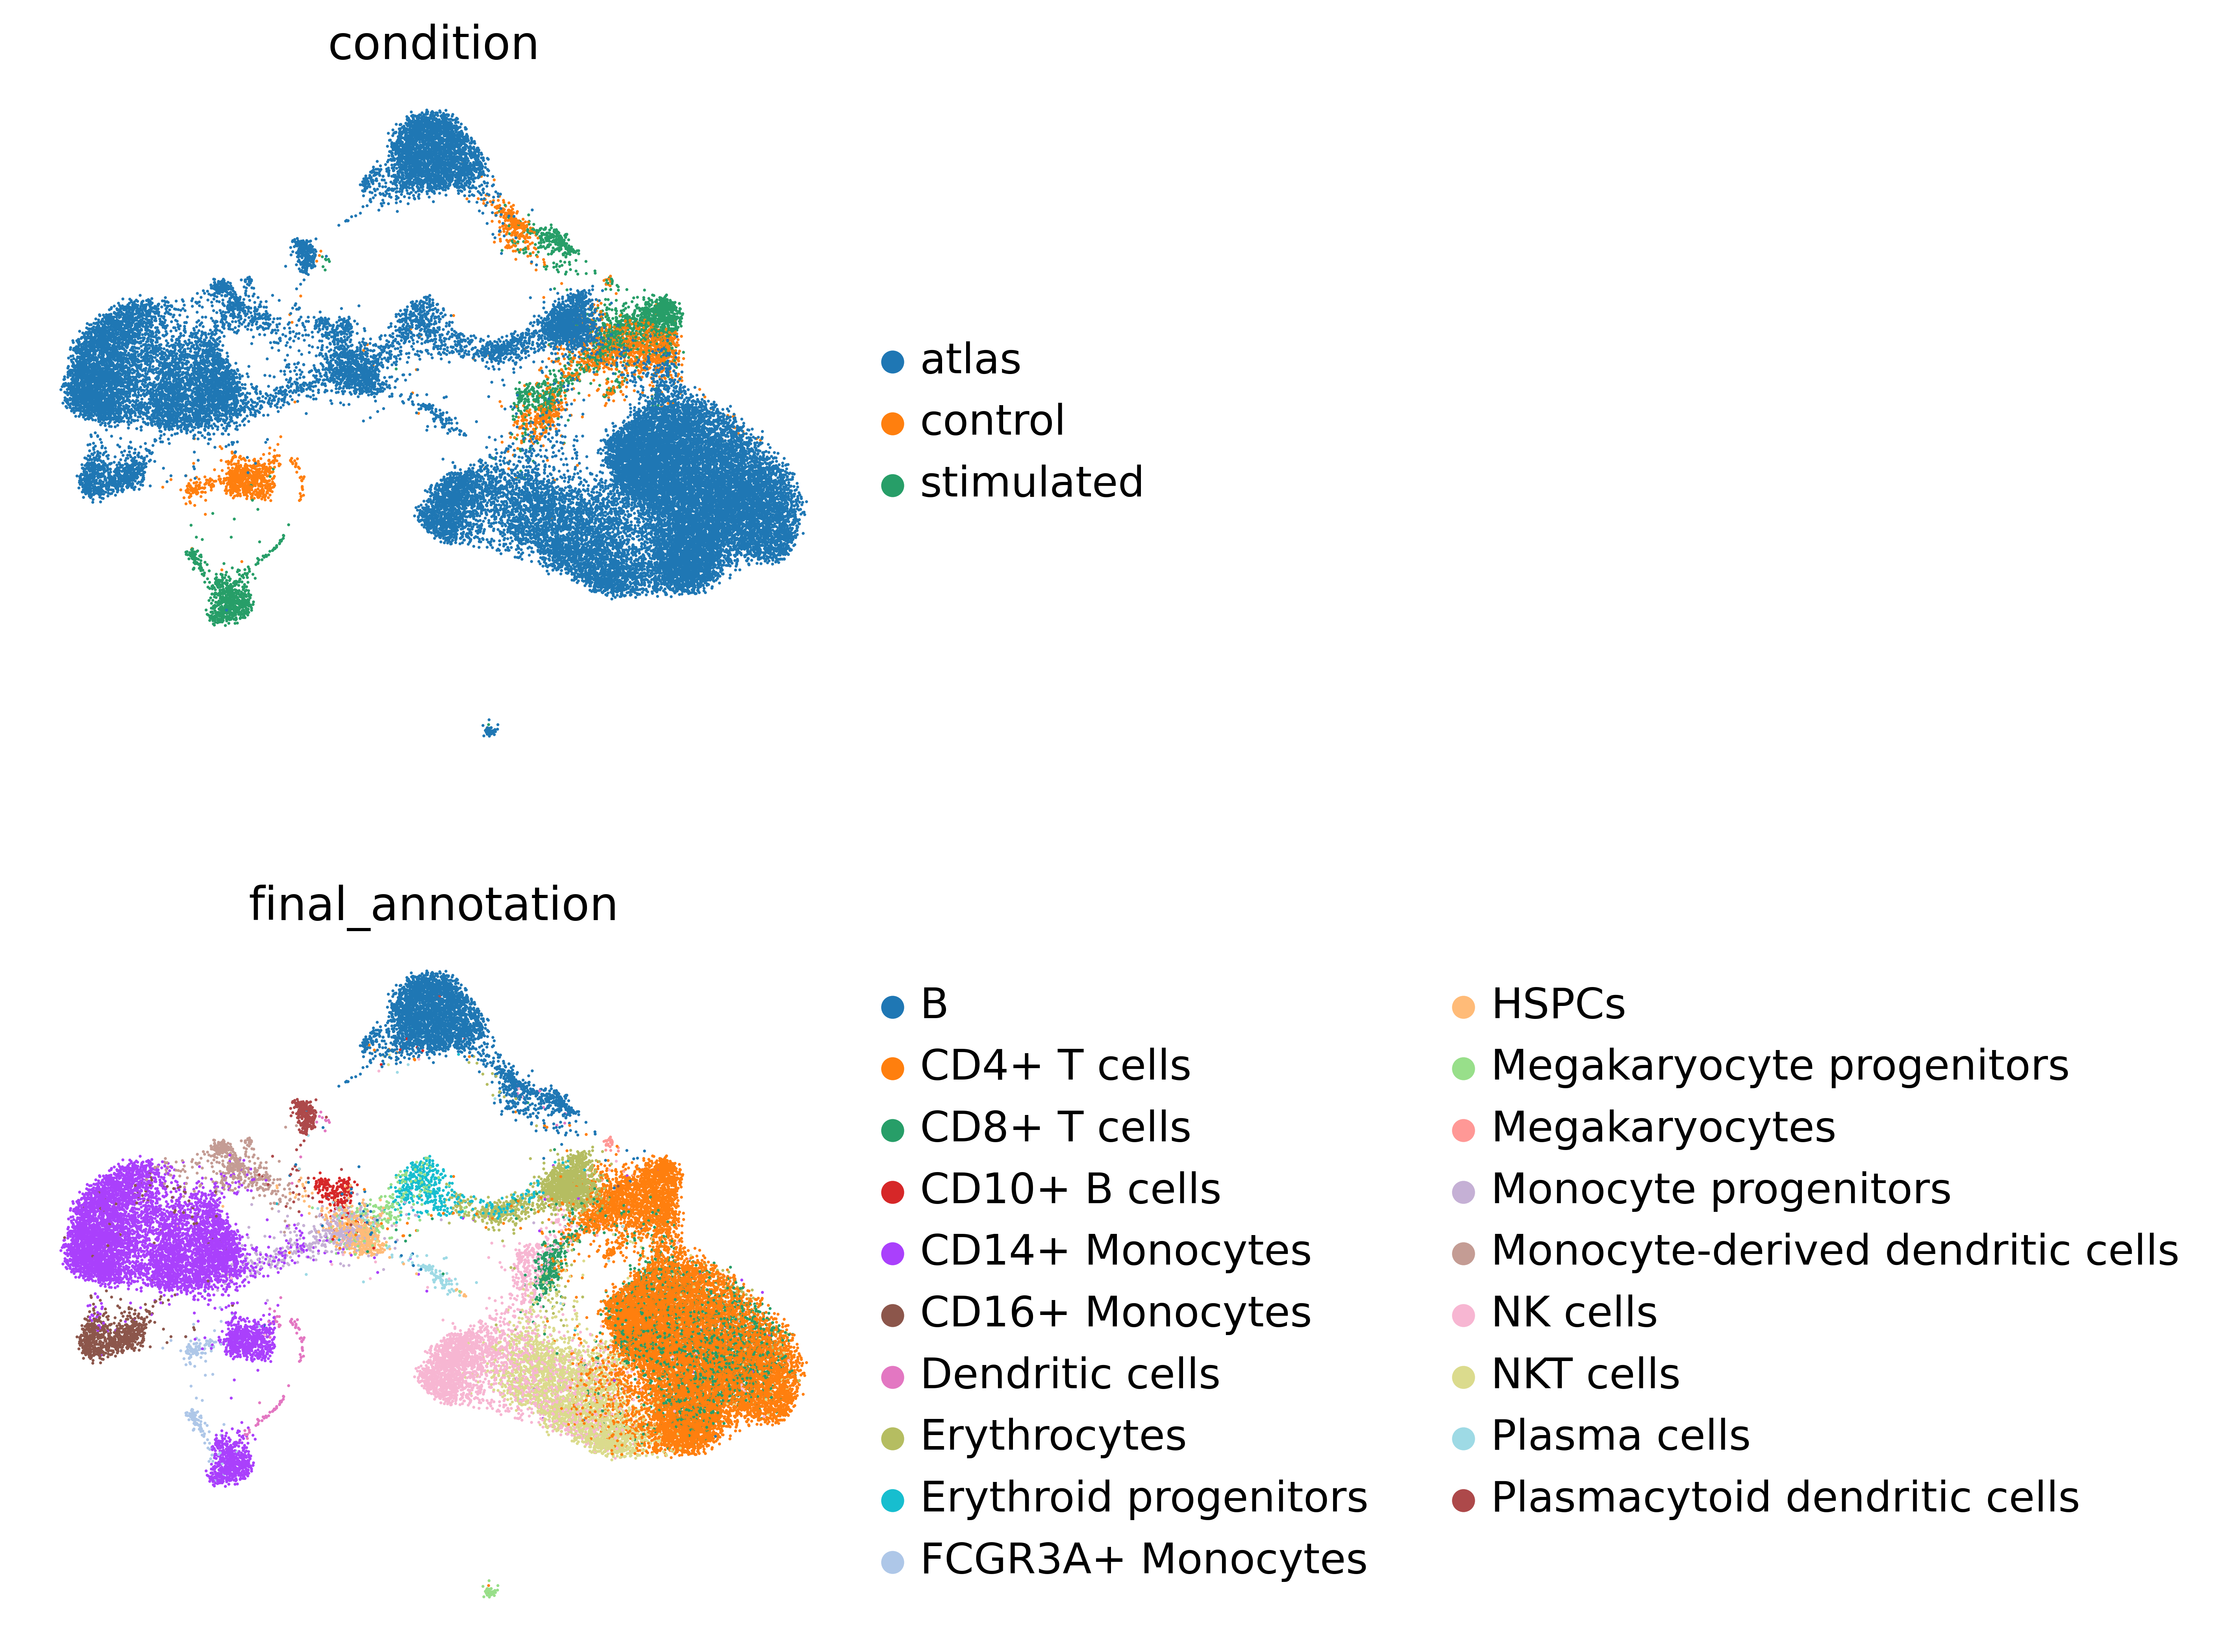

In [28]:
sc.pl.umap(adata, color=["condition", "final_annotation"], frameon=False, ncols=1)